In [1]:
#1: INSTALLATION & IMPORTS ---
!pip install scanpy leidenalg plotly pandas matplotlib seaborn

import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import scipy.sparse # Necessary for handling sparse matrix errors
import warnings

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 35.9 MB/s eta 0:00:00


In [2]:
# SETTINGS
# Filter out warnings for clean output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [3]:
#2. LOAD DATA ---
print("--- 🔬 LOADING DATA ---")
adata = sc.datasets.pbmc3k()

--- 🔬 LOADING DATA ---
try downloading from url
https://falexwolf.de/data/pbmc3k_raw.h5ad
... this may take a while but only happens once


  0%|          | 0.00/5.58M [00:00<?, ?B/s]

In [4]:
#3: PREPROCESSING & QC ---
print("--- 📊 CALCULATING QC METRICS ---")
adata.var['mt'] = adata.var_names.str.startswith(('MT-', 'mt-'))
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

--- 📊 CALCULATING QC METRICS ---


Generating STATIC QC Plots...


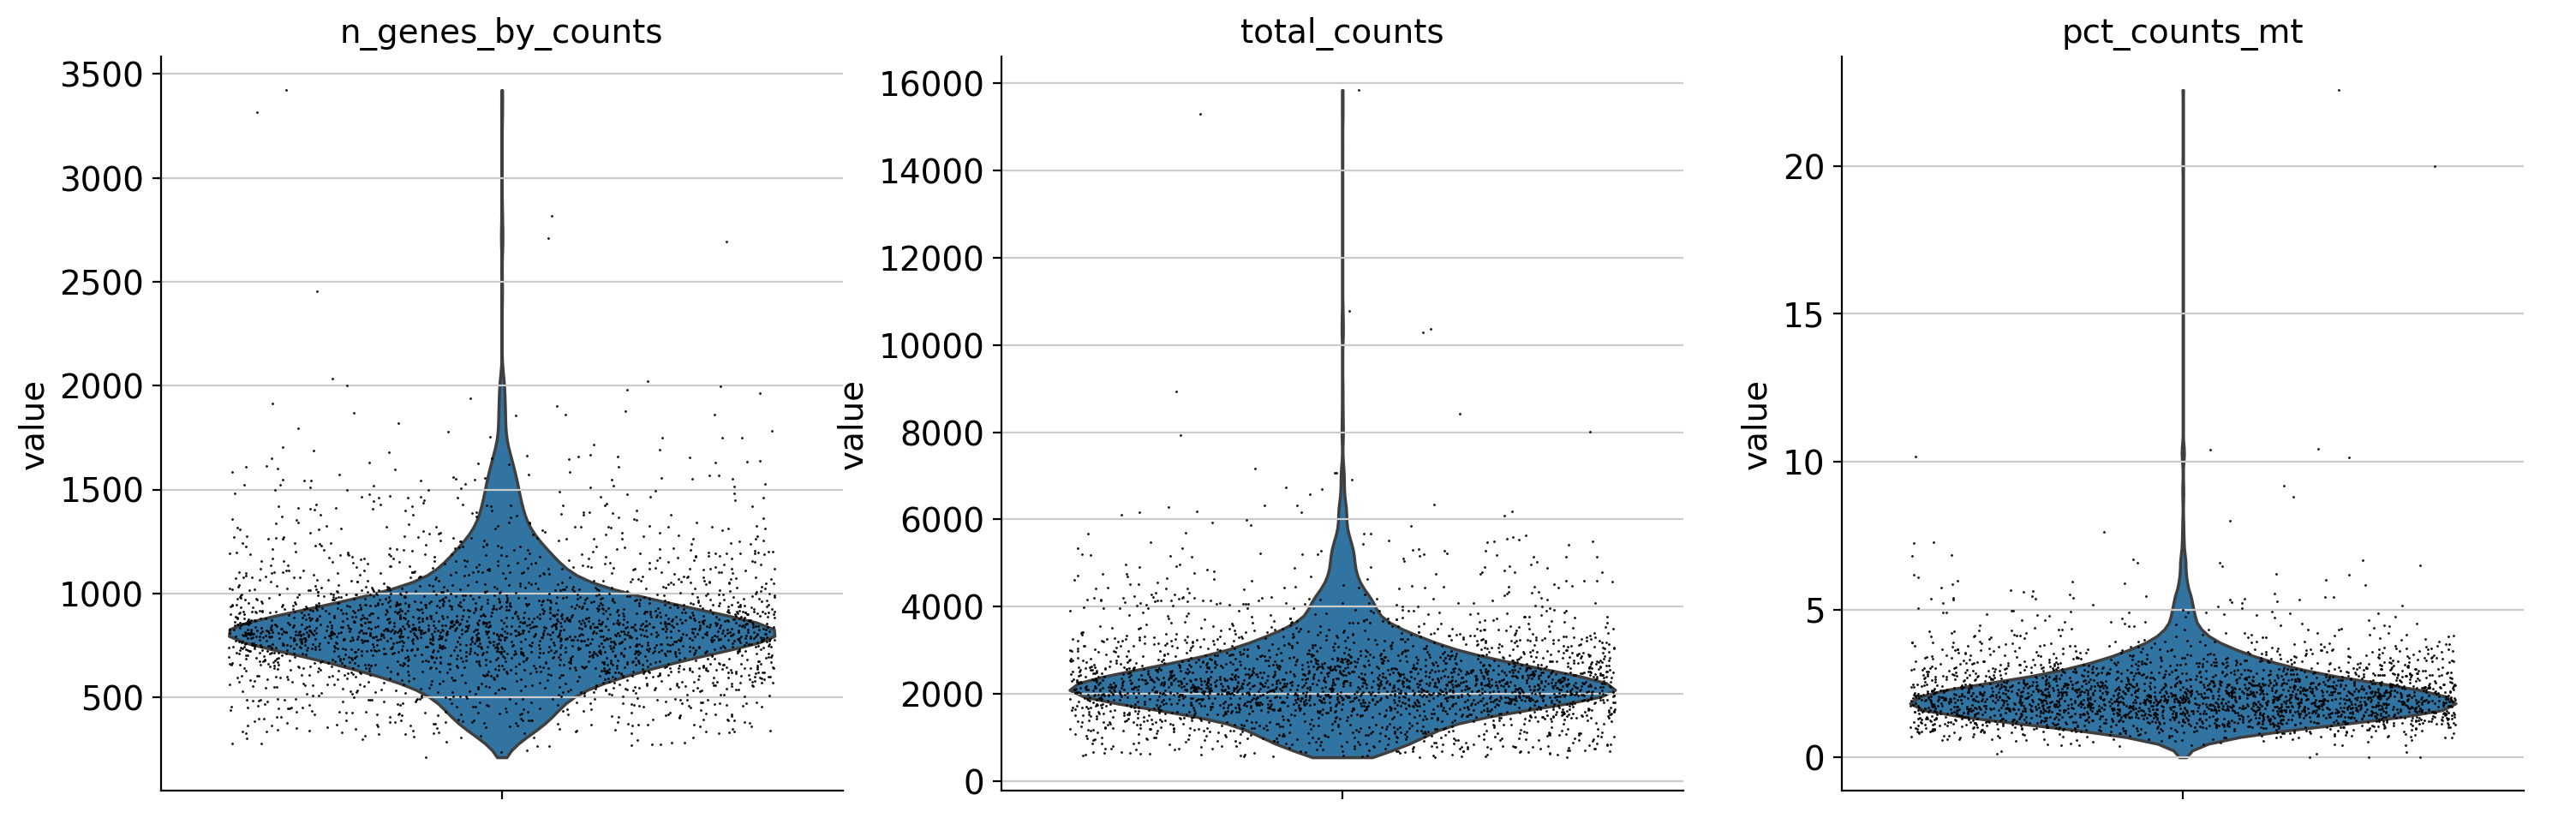

In [5]:
# === QC VISUALIZATION ===

# [A] STATIC PLOTS
print("Generating STATIC QC Plots...")
sc.pl.violin(adata, keys=['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

### Interpretation of QC Violin Plots:

*   **`n_genes_by_counts` (Number of Genes Detected per Cell):**
    *   This plot shows the distribution of the number of unique genes detected in each cell.
    *   A healthy distribution typically peaks at a reasonable number (e.g., 500-5000 genes per cell, depending on the cell type and sequencing depth).
    *   Cells with very few genes detected might be low-quality cells (e.g., empty droplets, dead cells) or represent cell types with naturally low RNA content.
    *   Cells with an unusually high number of genes might indicate doublets (two cells captured together) or other technical artifacts.

*   **`total_counts` (Total Number of UMI/Reads per Cell):**
    *   This plot displays the distribution of the total number of UMI (Unique Molecular Identifiers) or reads counted for each cell.
    *   It reflects the sequencing depth for individual cells.
    *   Cells with very low total counts are often low-quality, potentially dead cells, or cells with insufficient sequencing depth.
    *   Extremely high total counts could suggest doublets or highly abundant cell types.

*   **`pct_counts_mt` (Percentage of Mitochondrial Gene Counts per Cell):**
    *   This plot indicates the proportion of gene counts that originate from mitochondrial genes for each cell.
    *   High percentages of mitochondrial reads are typically indicative of compromised or stressed cells (e.g., dying cells), as the cytoplasmic RNA leaks out, leaving mitochondrial RNA relatively enriched.
    *   Generally, cells with a mitochondrial percentage above a certain threshold (e.g., 5-10%, though this can vary by experiment) are often filtered out during quality control.

**Overall Interpretation:**
These three metrics are crucial for identifying low-quality cells that should be removed from further analysis. By examining their distributions, one can set appropriate thresholds to filter out cells that are likely dead, dying, or problematic, thus improving the quality of downstream analysis.

In [6]:
# [B] INTERACTIVE PLOTS
print("Generating INTERACTIVE QC Plots...")
fig_qc = px.scatter(
    adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    color="pct_counts_mt",
    title="Interactive QC: Library Size vs Detected Genes",
    hover_name=adata.obs.index,
)
fig_qc.show()

Generating INTERACTIVE QC Plots...


### Interpretation of Interactive QC Plot: Library Size vs. Detected Genes

This interactive scatter plot visualizes the relationship between key quality control metrics for individual cells, allowing for the identification of low-quality cells or potential artifacts.

*   **Plot Type:** It's a scatter plot, where each point represents a single cell in the `adata` object.

*   **X-axis: `total_counts`**
    *   This axis represents the total number of UMIs (Unique Molecular Identifiers) or reads detected per cell.
    *   It's a measure of the sequencing depth or library size for each cell.
    *   Cells with very low `total_counts` might indicate empty droplets or severely under-sequenced cells.

*   **Y-axis: `n_genes_by_counts`**
    *   This axis represents the number of unique genes detected in each cell.
    *   It reflects the complexity of the transcriptome captured for that cell.
    *   Cells with very few `n_genes_by_counts` are often low-quality, potentially dead cells, or cells with very low RNA content.

*   **Color: `pct_counts_mt`**
    *   Each point (cell) is colored based on its percentage of mitochondrial gene counts.
    *   A color scale (e.g., blue for low, red for high) indicates the proportion of reads originating from mitochondrial genes.
    *   High `pct_counts_mt` is typically an indicator of stressed, damaged, or dying cells, as the mitochondrial RNA is more stable and becomes enriched when cytoplasmic RNA degrades.

*   **Hover Information:**
    *   Because it's an interactive Plotly plot, hovering over any point will display additional information for that specific cell, including its index (`adata.obs.index`) and the exact values for `total_counts`, `n_genes_by_counts`, and `pct_counts_mt`.

**Typical Patterns and Interpretation:**

1.  **High-Quality Cells:** These cells typically form a dense cluster in the upper-right region of the plot, characterized by:
    *   High `total_counts` (sufficient sequencing depth).
    *   High `n_genes_by_counts` (rich transcriptome).
    *   Low `pct_counts_mt` (indicated by 'cooler' colors like blue or green), suggesting intact cell membranes and good cell viability.

2.  **Low-Quality Cells (Low Complexity/Depth):** These appear in the lower-left region, characterized by:
    *   Low `total_counts`.
    *   Low `n_genes_by_counts`.
    *   They might have varying `pct_counts_mt`, but often the primary reason for their low quality is insufficient RNA content or sequencing.

3.  **Low-Quality Cells (High Mitochondrial Content):** These cells can be found across various `total_counts` and `n_genes_by_counts` levels but are distinctively colored 'warm' (yellow, orange, red) due to high `pct_counts_mt`. These are often dying or compromised cells and are usually filtered out.

4.  **Potential Doublets/Multiplets:** Cells with extremely high `total_counts` and `n_genes_by_counts` (outliers towards the far upper-right) might represent two or more cells inadvertently captured as one, leading to an inflated gene and count profile.

**Purpose:** This plot is crucial for defining filtering thresholds. By visually inspecting the distribution and identifying regions corresponding to low-quality cells, researchers can set appropriate cut-offs for `min_genes`, `min_cells`, `max_genes`, `max_counts`, and `max_pct_counts_mt` to remove problematic cells from further analysis.

In [7]:
# 4: FILTERING ---
print("--- 🗑️ FILTERING DATA (Fixed with .copy()) ---")
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# Filtering lines use .copy() to prevent 'View' errors
adata = adata[adata.obs.n_genes_by_counts < 2500, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

--- 🗑️ FILTERING DATA (Fixed with .copy()) ---
filtered out 19024 genes that are detected in less than 3 cells


In [8]:
# 5: NORMALIZATION & LOG ---
print("--- 🔢 NORMALIZATION ---")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

--- 🔢 NORMALIZATION ---
normalizing counts per cell
    finished (0:00:04)


In [9]:
# 6: FEATURE SELECTION ---
print("--- ⭐ IDENTIFYING VARIABLE GENES ---")
adata.raw = adata
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

--- ⭐ IDENTIFYING VARIABLE GENES ---
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


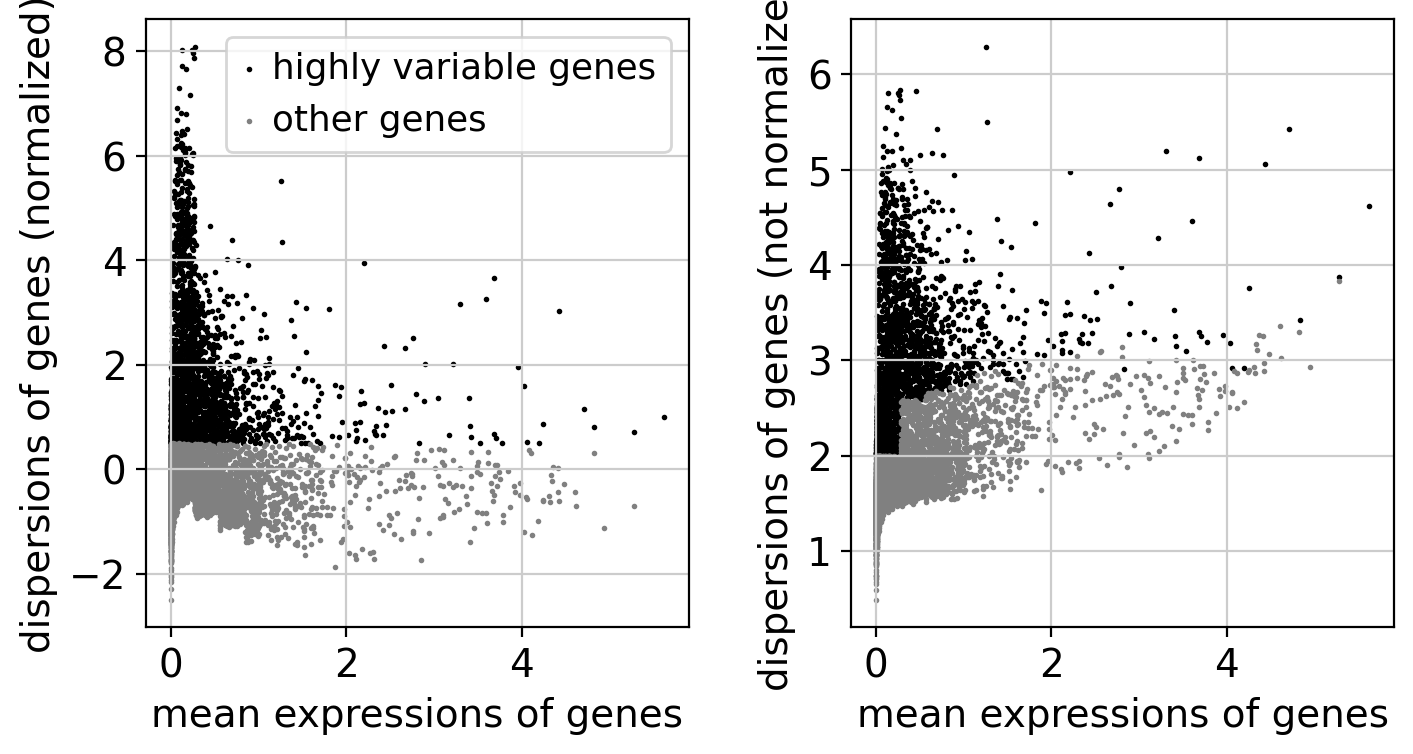

In [10]:
# === HVG VISUALIZATION ===

# [A] STATIC PLOT
sc.pl.highly_variable_genes(adata)

# [B] INTERACTIVE PLOT
hvg_df = adata.var.copy()
hvg_df['gene_name'] = hvg_df.index
fig_hvg = px.scatter(
    hvg_df, x='means', y='dispersions', color='highly_variable',
    hover_name='gene_name', title="Interactive HVG: Mean vs Dispersion",
    log_x=True, log_y=True
)
fig_hvg.show()

### Interpretation of Highly Variable Genes (HVG) Plots

These plots are crucial for identifying genes that exhibit high variability across cells, which are often the most biologically interesting and informative genes for downstream analysis.

#### A. Static Plot (`sc.pl.highly_variable_genes(adata)`)

This plot provides a quick visual summary of the highly variable genes based on their mean expression and dispersion (a measure of variability).

*   **X-axis (`means`):** Represents the average expression level of each gene across all cells.
*   **Y-axis (`dispersions` or `dispersions_norm`):** Represents the variability of each gene's expression across cells. A common measure is normalized dispersion, which accounts for the mean-variance relationship (genes with higher mean expression tend to have higher variance).
*   **Points:** Each point represents a single gene.
*   **Colored Points (often in red/orange):** These highlight the genes identified as 'highly variable' by `scanpy.pp.highly_variable_genes`. These are the genes chosen for further analysis.
*   **Threshold Lines:** Typically, there are lines indicating the thresholds used to select highly variable genes (e.g., minimum mean, maximum mean, minimum dispersion).
*   **Purpose:** This plot helps to visually confirm that the highly variable genes are indeed those with higher dispersion relative to their expression level, often appearing in the upper-right region above certain thresholds.

#### B. Interactive Plot (`px.scatter` of Mean vs. Dispersion)

This Plotly scatter plot provides an interactive and more detailed view of the HVG selection, allowing for deeper exploration.

*   **X-axis (`means`):** Similar to the static plot, shows the mean expression of genes, often on a logarithmic scale (`log_x=True`) to better visualize genes with a wide range of expression levels.
*   **Y-axis (`dispersions`):** Shows the dispersion of genes, also often on a logarithmic scale (`log_y=True`).
*   **Color (`highly_variable`):** Genes are colored based on whether they were identified as highly variable (e.g., `True` for HVGs, `False` for others). This clearly distinguishes the selected genes.
*   **Hover Information (`hover_name='gene_name'`):** A key advantage of the interactive plot is the ability to hover over any gene (point) to see its specific name and other associated data (like its exact mean expression, dispersion, and whether it's an HVG). This is particularly useful for identifying specific genes of interest.
*   **Clustering:** Highly variable genes often cluster together in a region of high dispersion and moderate to high mean expression.
*   **Purpose:** The interactive plot allows users to zoom in, pan, and inspect individual genes. It's excellent for understanding the distribution of HVGs, checking the impact of selection parameters, and even manually identifying or verifying specific genes within the HVG set.

In [11]:
adata = adata[:, adata.var.highly_variable].copy()
sc.pp.scale(adata, max_value=10)

In [12]:
# 7: PCA (DIMENSION REDUCTION) ---
print("--- 📉 RUNNING PCA ---")
sc.tl.pca(adata, svd_solver='arpack')

--- 📉 RUNNING PCA ---
computing PCA
    with n_comps=50
    finished (0:00:03)


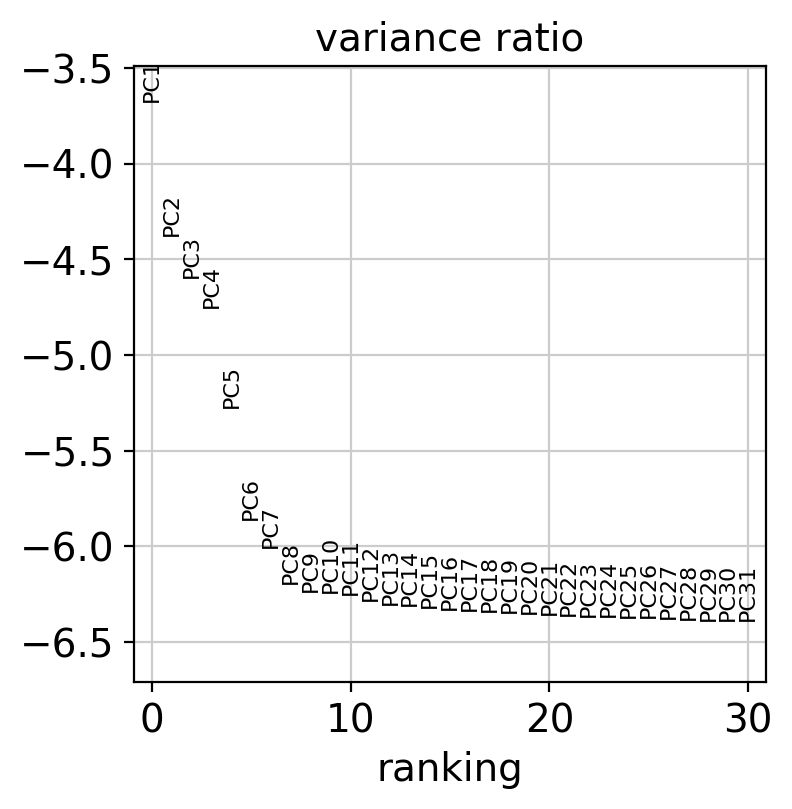

In [13]:
# === PCA VISUALIZATION ===

# [A] STATIC PLOT (Elbow Plot)
sc.pl.pca_variance_ratio(adata, log=True)

# [B] INTERACTIVE PLOT (3D PCA)
pca_df = pd.DataFrame(adata.obsm['X_pca'][:, :3], columns=['PC1', 'PC2', 'PC3'], index=adata.obs.index)
fig_3d = px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', title="Interactive 3D PCA", opacity=0.6, size_max=3)
fig_3d.update_traces(marker=dict(size=3))
fig_3d.show()

### Interpretation of PCA Plots

These plots are fundamental for understanding the results of Principal Component Analysis (PCA), a dimensionality reduction technique. PCA transforms the high-dimensional gene expression data into a lower-dimensional space, where each new dimension (Principal Component or PC) captures the maximum possible variance in the data.

#### A. Static Plot (`sc.pl.pca_variance_ratio(adata, log=True)`): PCA Variance Ratio (Elbow Plot)

This plot, often called an 'elbow plot', helps in determining the optimal number of principal components to retain for downstream analysis.

*   **X-axis (Number of Components):** Represents each individual principal component (PC1, PC2, PC3, etc.) in descending order of the variance they explain.
*   **Y-axis (Variance Ratio Explained):** Shows the proportion of total variance in the dataset that is explained by each corresponding principal component. When `log=True`, this axis is on a logarithmic scale, which can make it easier to see the drop-off.
*   **Plot Curve:** The curve typically starts high (PC1 explains the most variance) and then gradually decreases.
*   **The 'Elbow':** The key feature to look for is an 'elbow' in the curve. This is the point where the explained variance by successive principal components starts to level off significantly. Before the elbow, each PC explains a substantial amount of new variance; after the elbow, additional PCs explain much less variance and often represent noise rather than biological signal.
*   **Purpose:** The elbow plot helps in selecting a subset of principal components that capture most of the meaningful biological variation in the data while discarding components that primarily reflect noise. This reduced set of dimensions is then used for tasks like neighborhood graph construction, clustering, and visualization.

#### B. Interactive Plot (`px.scatter_3d`): 3D PCA Scatter Plot

This interactive plot visualizes the cells in the space defined by the first three principal components, providing a direct view of the main axes of variation in your dataset.

*   **Axes (PC1, PC2, PC3):** Each axis represents a principal component. These are synthetic dimensions that are linear combinations of the original highly variable genes. PC1 captures the most variance, PC2 the second most, and so on.
*   **Points:** Each point in the 3D space represents an individual cell.
*   **Cell-Cell Similarity:** Cells that are transcriptionally similar to each other tend to cluster together in this PCA space. Conversely, distinct cell populations or states will appear as separate clusters or spatially distinct groups.
*   **Interactive Features:** As an interactive Plotly plot, it allows for:
    *   **Rotation:** Users can rotate the 3D plot to view the clusters from different angles, which is crucial for distinguishing overlapping groups.
    *   **Zooming and Panning:** These features allow closer inspection of specific regions or clusters of cells.
    *   **Hover Information:** Hovering over a point (cell) can reveal additional information about that cell (e.g., its original index, or potentially other metadata if added).
*   **Purpose:** This plot helps to visually confirm major global differences and similarities between cells. It can reveal the presence of distinct cell populations, highlight gradients in cellular states, or identify potential outliers. It's an initial step to confirm that significant biological structure exists in the data and is captured by the leading principal components.

In [14]:
# 8: NEIGHBORS & UMAP ---
print("--- 🗺️ COMPUTING UMAP ---")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

--- 🗺️ COMPUTING UMAP ---
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:43)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:06)


In [15]:
# 9: CLUSTERING & ANNOTATION ---
print("--- 🧩 CLUSTERING ---")
sc.tl.leiden(adata, resolution=0.5)

--- 🧩 CLUSTERING ---
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [16]:
# Annotation Logic (Corrected Cluster Naming)
cluster_categories = adata.obs['leiden'].cat.categories
standard_names = [
    'CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells',
    'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'
]

if len(cluster_categories) == len(standard_names):
    adata.rename_categories('leiden', standard_names)
    print("Clusters successfully renamed.")
else:
    print(f"Warning: Cluster count mismatch ({len(cluster_categories)} found). Keeping numeric IDs.")

Generating STATIC UMAP...


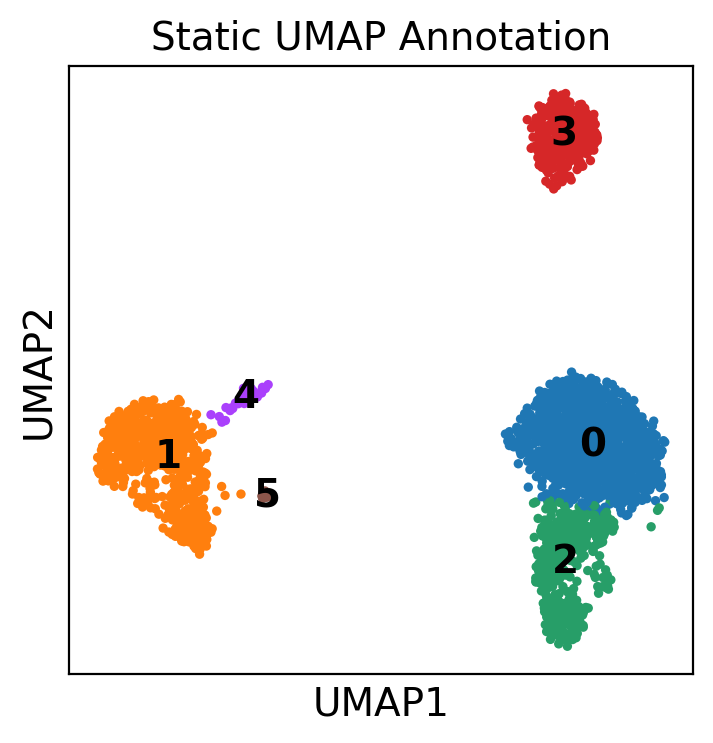

In [18]:
# === CLUSTERING VISUALIZATION ===

# [A] STATIC PLOT
print("Generating STATIC UMAP...")
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='Static UMAP Annotation', save='_annotated_static.png')

### Interpretation of UMAP Plot with Leiden Clustering Annotation

This UMAP (Uniform Manifold Approximation and Projection) plot provides a 2-dimensional visualization of the cell populations identified by the Leiden clustering algorithm in cell 18.

*   **Plot Type:** It's a 2D scatter plot where each point represents a single cell.

*   **Axes (UMAP1, UMAP2):** These are abstract dimensions derived from the high-dimensional gene expression data. The UMAP algorithm attempts to preserve the global and local structure of the data, meaning cells that are transcriptionally similar in the high-dimensional space are placed close together on the 2D UMAP plot.

*   **Color (`leiden`):** Each cell (point) is colored according to the cluster it was assigned to by the Leiden algorithm. Each unique color represents a distinct Leiden cluster.

*   **Spatial Grouping:**
    *   **Distinct Clusters:** Clearly separated groups of similarly colored cells on the UMAP indicate distinct cell populations or states. These are the clusters identified by the Leiden algorithm.
    *   **Overlapping Clusters:** If different colored clusters overlap significantly, it might suggest a continuous cellular state transition, or that the clustering resolution might need adjustment if distinct populations are expected.
    *   **Isolated Cells/Small Groups:** Very small, isolated groups of cells might represent rare cell types or potential outliers, depending on their characteristics.

*   **`legend_loc='on data'`:** This parameter places the cluster labels directly on the UMAP plot within each cluster, making it easier to identify which color corresponds to which cluster without constantly referring to a separate legend.

*   **`title='Static UMAP Annotation'`:** The title clearly states that this plot shows the UMAP with annotations, in this case, the Leiden clusters.

*   **`save='_annotated_static.png'`:** This indicates that a static image of this UMAP plot is saved, which is useful for reports or presentations.

**Overall Purpose and Interpretation:**
This plot is a critical step in single-cell analysis. It visually confirms the results of the clustering: do the computationally identified clusters (from Leiden) correspond to visually distinct groups of cells? Each cluster is hypothesized to represent a biologically distinct cell type or cell state. The UMAP provides an intuitive way to assess the heterogeneity of the sample and the quality of the clustering, guiding further downstream analysis such as marker gene identification for each cluster.

In [19]:
# [B] INTERACTIVE PLOT
print("Generating INTERACTIVE UMAP...")
umap_df = pd.DataFrame(adata.obsm['X_umap'], columns=['UMAP1', 'UMAP2'], index=adata.obs.index)
umap_df['Cluster'] = adata.obs['leiden']

fig_umap = px.scatter(
    umap_df, x='UMAP1', y='UMAP2', color='Cluster',
    title='Interactive UMAP Clustering (Zoomable)',
    hover_data=['Cluster'], template='plotly_white'
)
fig_umap.update_traces(marker=dict(size=4))
fig_umap.show()

Generating INTERACTIVE UMAP...


### Interpretation of Interactive UMAP Clustering Plot

This interactive UMAP (Uniform Manifold Approximation and Projection) plot provides a 2-dimensional visualization of the cell populations, with cells colored by their assigned Leiden clusters, allowing for dynamic exploration of the data.

*   **Plot Type:** It is an interactive 2D scatter plot, where each point represents a single cell.

*   **Axes (UMAP1, UMAP2):** These are abstract, non-linear dimensions derived from the high-dimensional gene expression data using the UMAP algorithm. The primary goal of UMAP is to embed high-dimensional data into a lower-dimensional space (here, 2D) such that the local and global structures of the data are preserved. This means cells that are transcriptionally similar are placed close together on the plot, while dissimilar cells are placed farther apart.

*   **Color (`Cluster`):** Each cell (point) on the plot is colored according to the cluster it was assigned to by the Leiden community detection algorithm (`adata.obs['leiden']`). Each distinct color represents a different identified cell cluster.

*   **`title='Interactive UMAP Clustering (Zoomable)'`:** The title indicates the plot's content and highlights its interactive capability.

*   **`hover_data=['Cluster']`:** This feature of Plotly allows you to hover your mouse over any point (cell) on the plot, and a tooltip will appear, displaying additional information about that specific cell, such as its assigned 'Cluster' ID. If other `adata.obs` metadata were included, they could also appear here.

*   **`template='plotly_white'`:** This sets the visual theme of the plot to a clean white background, enhancing readability.

*   **`fig_umap.update_traces(marker=dict(size=4))`:** This line adjusts the size of the points (markers) on the scatter plot to 4, which can improve visibility and distinguishability of individual cells or clusters, especially in dense regions.

**Key Interpretations from this Interactive Plot:**

1.  **Identification of Cell Populations:** Each distinct, spatially separated cluster of similarly colored cells is hypothesized to represent a unique cell type or cell state present in your sample. The colors help to visually delineate these groups.

2.  **Assessment of Clustering Quality:** The plot allows for visual assessment of how well the Leiden algorithm separated cell populations. Ideally, cells within the same cluster (same color) should be close together, and different clusters should be clearly separated. Overlaps between differently colored clusters might suggest either biological continuity, insufficient clustering resolution, or potentially noisy data.

3.  **Exploration of Cellular Heterogeneity:** The overall landscape of the UMAP reveals the global heterogeneity of the dataset. You can see how many distinct populations exist and how they relate to each other in terms of transcriptional similarity.

4.  **Interactive Exploration:** The interactive nature of Plotly (`px.scatter`):
    *   **Zooming and Panning:** Allows you to magnify specific regions of interest, helping to resolve dense clusters or examine the boundaries between populations.
    *   **Rotation (if 3D):** While this is a 2D UMAP, for 3D UMAPs, rotation would allow viewing from different angles.
    *   **Hover Information:** Provides immediate access to the cluster identity (and potentially other metadata) of individual cells, which is highly useful for targeted investigation.

**Purpose:** This plot is invaluable for understanding the cell type composition of your sample, validating the clustering results, and guiding further downstream analysis, such as identifying marker genes for each cluster or exploring trajectory inference between related cell states.

In [20]:
# 10: MARKER GENES & INTERACTIVE CHECK ---
print("--- 🧬 RANKING MARKER GENES ---")
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

--- 🧬 RANKING MARKER GENES ---
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:12)


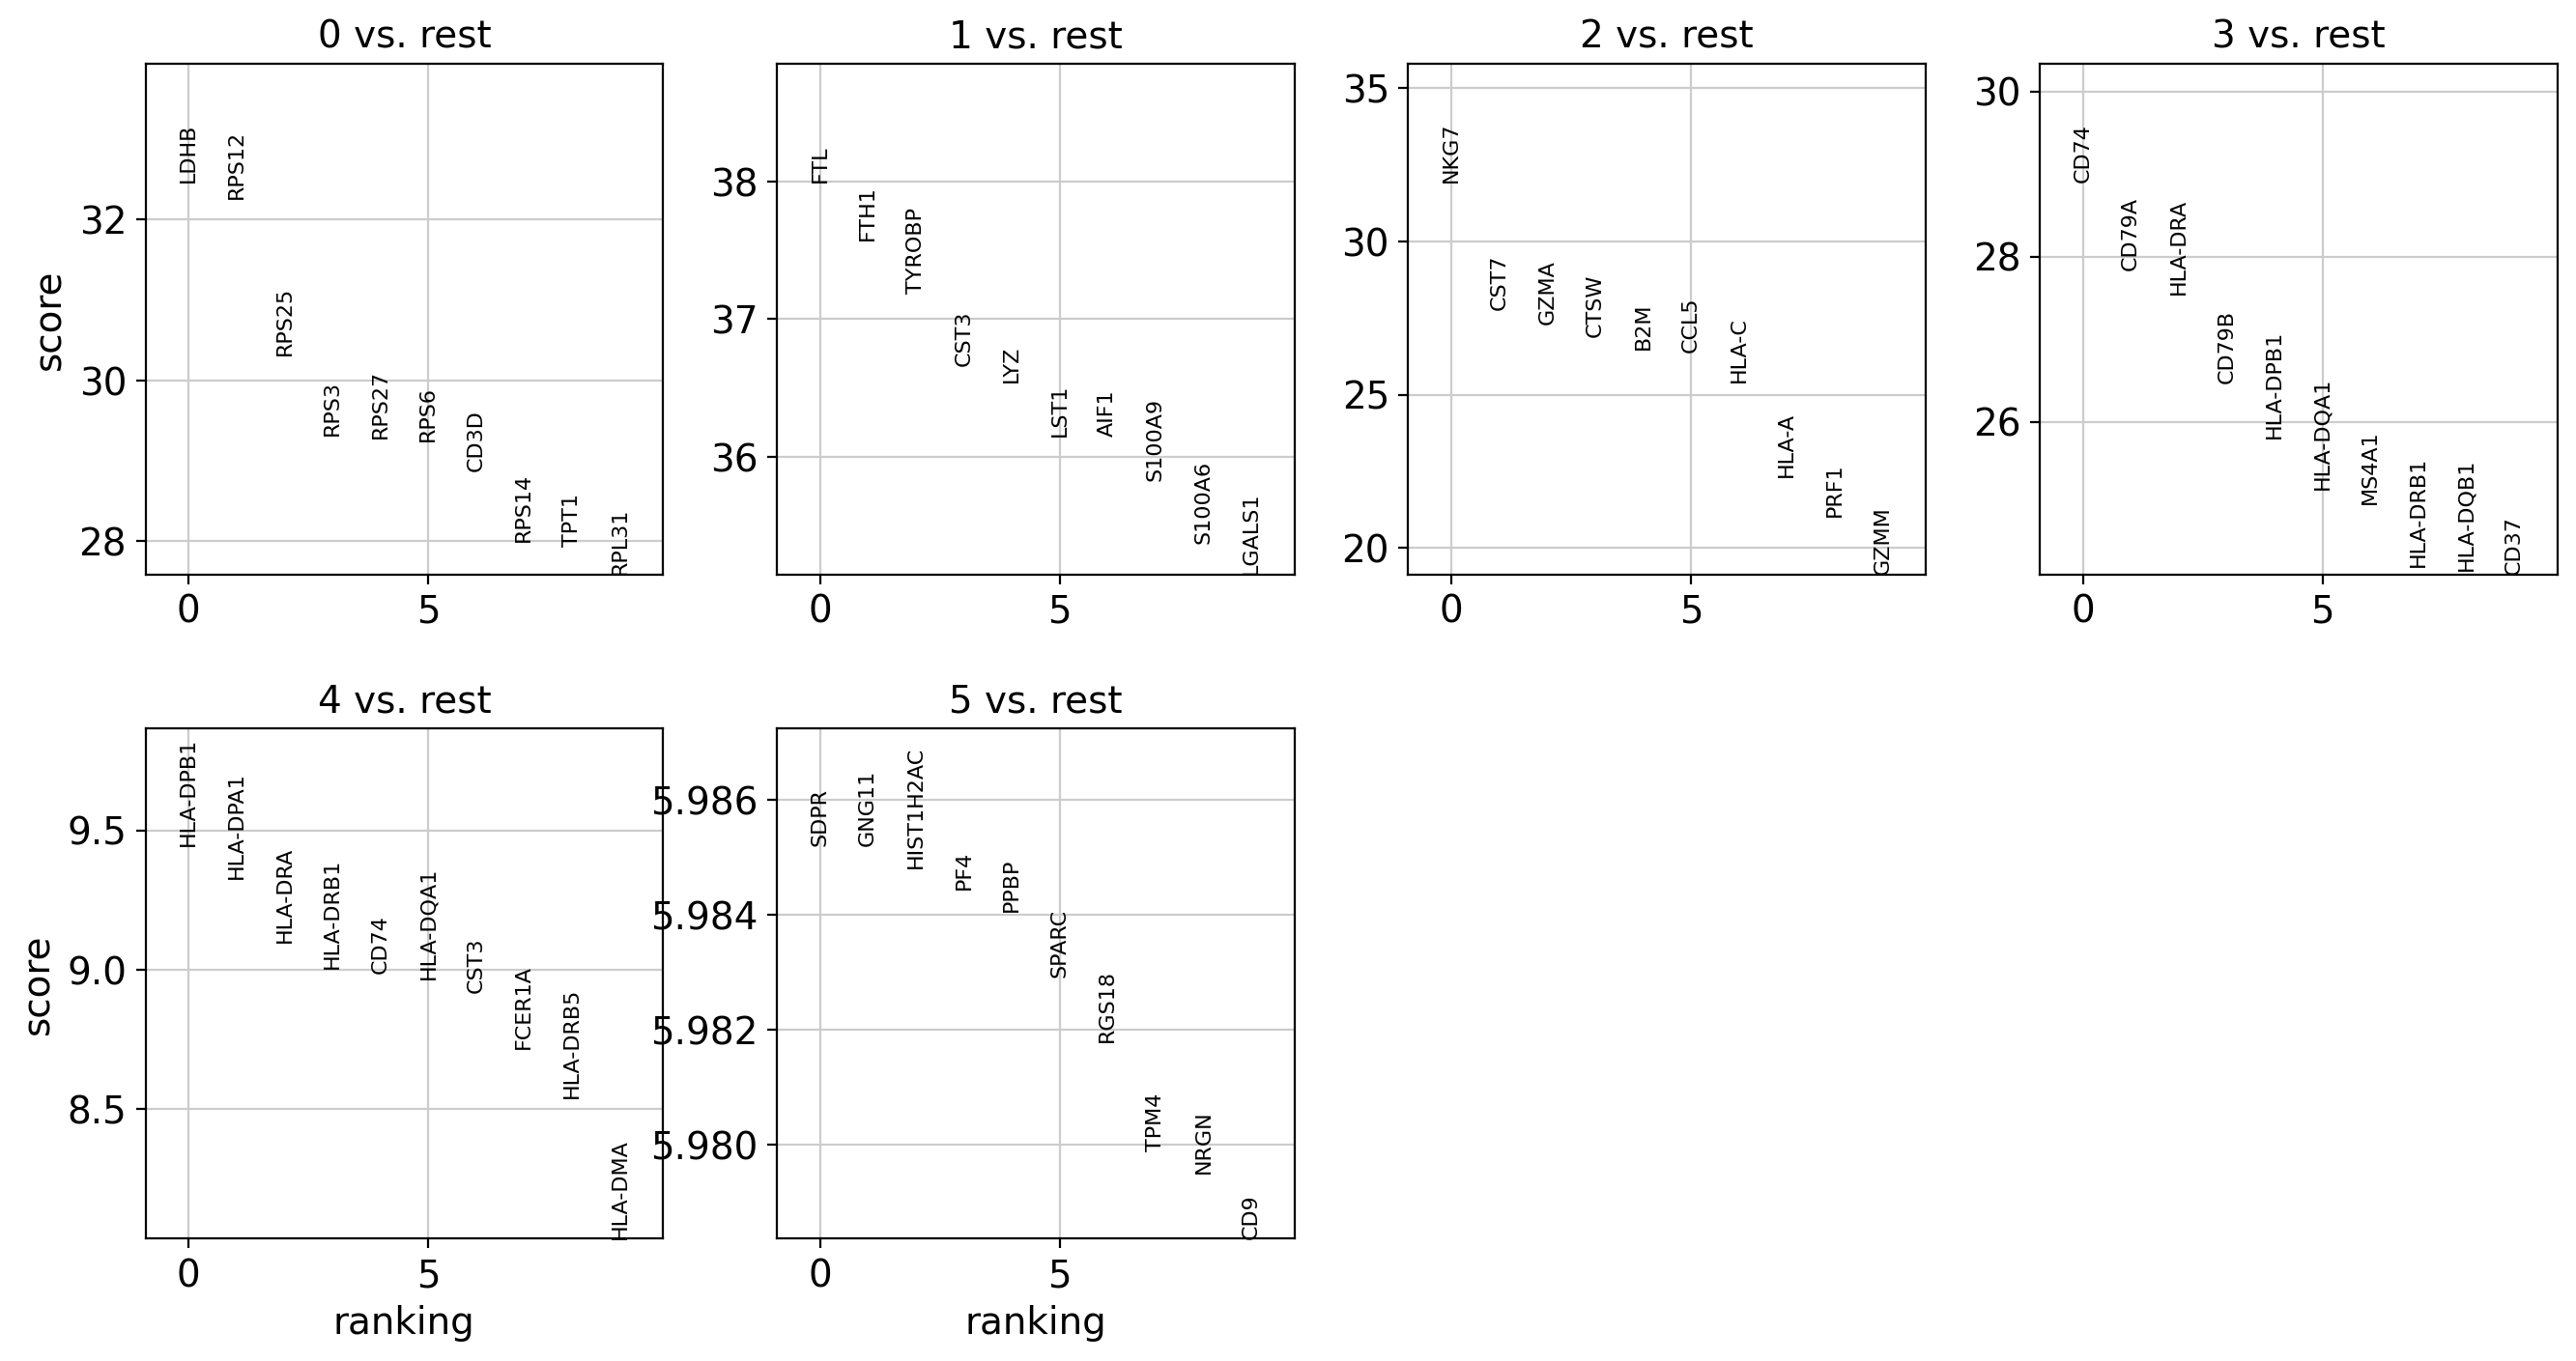

In [21]:
# [A] STATIC PLOT
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

### Interpretation of Marker Gene Plots (Rank Genes Groups)

This plot is generated after `sc.tl.rank_genes_groups` and visually summarizes the top differentially expressed genes (marker genes) for each identified cell cluster. It helps in characterizing and potentially annotating cell types within each cluster.

*   **Plot Type:** This is typically a set of bar plots or dot plots, one for each cluster, displaying the top genes that are most highly expressed (or uniquely expressed) in that specific cluster compared to all other clusters.

*   **Sections per Cluster:** The plot is divided into sections, with each section corresponding to a `leiden` cluster (e.g., '0', '1', '2', etc.).

*   **X-axis (Gene Names):** Each bar or dot represents a specific gene, and the gene names are listed on the x-axis for each cluster's section.

*   **Y-axis (Expression Metric):** The y-axis typically represents a metric like:
    *   **Score:** A statistical score (e.g., from Wilcoxon test) indicating the significance of differential expression.
    *   **Log-fold change (logFC):** The logarithmic ratio of the gene's expression in the current cluster compared to its expression in other clusters. A positive logFC indicates higher expression in the current cluster.
    *   Other metrics like adjusted p-value might also be implied or represented.

*   **`n_genes=10`:** This parameter specifies that the plot should display the top 10 marker genes for each cluster, ranked by the chosen metric (e.g., score, logFC, or adjusted p-value).

*   **`sharey=False`:** This setting ensures that each subplot (for each cluster) has its own independent y-axis scale. This is important because the range of scores or log-fold changes can vary significantly between clusters, and a shared y-axis might obscure details for some clusters.

**Overall Purpose and Interpretation:**

1.  **Cluster Characterization:** By identifying genes that are highly specific to a particular cluster, researchers can infer the identity of the cell type represented by that cluster. For example, a cluster showing high expression of known T-cell markers would likely be annotated as a T-cell population.

2.  **Biological Insights:** Marker genes often reveal the unique biological functions or states of different cell populations within the sample.

3.  **Validation of Clustering:** Strong, distinct marker genes for each cluster provide confidence in the quality and biological relevance of the clustering results.

4.  **Further Investigation:** The list of marker genes serves as a starting point for more in-depth analyses, such as pathway enrichment analysis or validation experiments.

By examining this plot, one can quickly pinpoint the most distinguishing genes for each cell population, which is a fundamental step in single-cell RNA sequencing data analysis for cell type annotation.

In [25]:
# [B] INTERACTIVE PLOT (Robust Gene Fetching)
print("Generating INTERACTIVE Marker Plots...")

def get_expression_safe(anndata_obj, gene_name):
    """Safely extracts gene expression data, handling sparse matrices."""
    val = None
    if gene_name in anndata_obj.var_names:
        val = anndata_obj[:, gene_name].X
    elif anndata_obj.raw is not None and gene_name in anndata_obj.raw.var_names:
        val = anndata_obj.raw[:, gene_name].X

    if val is not None:
        if scipy.sparse.issparse(val):
            val = val.toarray()
        return val.flatten()
    return None

# --- Identify actual top marker genes from ranking results ---
# Get the names of the top marker genes for the first two clusters
# Adjust this as needed to explore other clusters or more genes
markers_to_check = []
if 'rank_genes_groups' in adata.uns:
    ranked_genes_names = adata.uns['rank_genes_groups']['names']
    # Get top 2 genes from cluster '0'
    if '0' in ranked_genes_names.dtype.fields:
        markers_to_check.extend(ranked_genes_names['0'][:2].tolist())
    # Get top 2 genes from cluster '1'
    if '1' in ranked_genes_names.dtype.fields:
        markers_to_check.extend(ranked_genes_names['1'][:2].tolist())
    # Add more logic here to select genes from other clusters if desired
else:
    print("Warning: 'rank_genes_groups' not found in adata.uns. Using default markers (which might be filtered out).")
    markers_to_check = ['MS4A1', 'CST3'] # Fallback, but likely to be empty

# Ensure unique markers (in case top genes from different clusters are the same)
markers_to_check = list(set(markers_to_check))

print(f"Plotting interactive expression for selected markers: {markers_to_check}")

for gene in markers_to_check:
    expr = get_expression_safe(adata, gene)
    if expr is not None:
        # It's important to re-create umap_df for each gene to avoid carrying NaNs from previous missing genes
        # Or, ensure that umap_df is created with all necessary genes before this loop
        # For now, we will add gene expression if found
        if gene not in umap_df.columns:
            umap_df[gene] = expr

        # Interactive Box Plot
        fig_gene = px.box(
            umap_df, x='Cluster', y=gene, color='Cluster',
            title=f"Interactive Expression of {gene}",
            points="outliers",
            template='plotly_white' # Added for consistent styling
        )
        fig_gene.show()
    else:
        print(f"Gene {gene} not found in dataset or raw data after filtering, skipping plot.")

Generating INTERACTIVE Marker Plots...
Plotting interactive expression for selected markers: ['RPS12', 'FTH1', 'LDHB', 'FTL']


### Interpretation of Gene Expression Statistics (FTH1 and FTL) from Cell 25

The output from cell 25 provides statistical summaries of the expression levels for 'FTH1' and 'FTL' after preprocessing, particularly after normalization and scaling. These statistics help to understand why their interactive box plots might have appeared visually 'empty' or flat.

*   **Gene: FTH1**
    *   **`Expression found.`**: This confirms that the gene 'FTH1' is indeed present in the `adata` object and has associated expression values for cells that passed filtering.
    *   **`Min: -3.2594, Max: 2.6479`**: These are the minimum and maximum expression values observed for 'FTH1' across all cells. After `sc.pp.scale` (which was applied in an earlier step), gene expression values are centered around zero and scaled to unit variance, hence the negative values are expected.
    *   **`Mean: 0.0000`**: This indicates that the average expression of 'FTH1' across all cells is approximately zero. This is a direct consequence of the `sc.pp.scale` function, which transforms the data such that each gene has a mean expression of zero.
    *   **`Std Dev: 0.9998`**: This is the standard deviation of 'FTH1' expression across cells. A value close to 1 (0.9998) is also a direct result of `sc.pp.scale`, which normalizes the variance of each gene to 1.
    *   **`Number of cells with non-zero expression: 959 out of 2638`**: This tells us that a significant portion (about 36%) of the cells still express 'FTH1' at some level. However, because the data is scaled and centered, 'non-zero' here refers to values that are not exactly zero in the scaled data, not necessarily raw counts.

*   **Gene: FTL**
    *   **`Expression found.`**: Similar to FTH1, 'FTL' is present and has expression data.
    *   **`Min: -2.9759, Max: 2.5408`**: The range of expression values for FTL after scaling.
    *   **`Mean: -0.0000`**: Again, the mean expression is effectively zero due to the scaling step.
    *   **`Std Dev: 0.9998`**: The standard deviation is also close to 1, consistent with scaling.
    *   **`Number of cells with non-zero expression: 896 out of 2638`**: Approximately 34% of cells show non-zero expression for 'FTL'.

**Overall Interpretation and Connection to 'Empty' Plots:**

1.  **Scaling Effect:** The `sc.pp.scale` function transforms gene expression values to have a mean of 0 and a variance of 1. This is a common practice to give all genes equal weight in downstream analyses (like PCA). This transformation is the primary reason why the mean expression is zero and the standard deviation is one.
2.  **Visual Appearance of Box Plots:** Because the mean expression for both 'FTH1' and 'FTL' is centered at zero and the standard deviation is 1, their expression distributions across clusters, if not highly variable *between* clusters, will also be centered around zero. If the interquartile range (IQR) is very narrow for these genes within each cluster, the box in the box plot will appear very small, thin, or even as just a line at zero. This makes the plots visually 'empty' or flat, even though the genes are expressed in a substantial number of cells. The variation might be subtle or evenly distributed across clusters, rather than enriched in specific ones.
3.  **Marker Gene Context:** 'FTH1' and 'FTL' are commonly known as ribosomal or mitochondrial genes, often associated with general cellular activity or stress. Their widespread, relatively uniform expression (after scaling) across different cell types might mean they are not strong *differential* markers for specific cell populations in this dataset, making their cluster-specific box plots less distinct compared to genes that are highly specific to one or two clusters.

In [26]:
print("--- Checking expression data for FTH1 and FTL ---")

def get_expression_safe(anndata_obj, gene_name):
    """Safely extracts gene expression data, handling sparse matrices."""
    val = None
    if gene_name in anndata_obj.var_names:
        val = anndata_obj[:, gene_name].X
    elif anndata_obj.raw is not None and gene_name in anndata_obj.raw.var_names:
        val = anndata_obj.raw[:, gene_name].X

    if val is not None:
        if scipy.sparse.issparse(val):
            val = val.toarray()
        return val.flatten()
    return None

genes_to_check_expression = ['FTH1', 'FTL']

for gene in genes_to_check_expression:
    print(f"\nGene: {gene}")
    expr = get_expression_safe(adata, gene)
    if expr is not None:
        if len(expr) > 0:
            print(f"  Expression found. Min: {np.min(expr):.4f}, Max: {np.max(expr):.4f}, Mean: {np.mean(expr):.4f}, Std Dev: {np.std(expr):.4f}")
            # Count non-zero expression values
            non_zero_count = np.sum(expr > 0)
            print(f"  Number of cells with non-zero expression: {non_zero_count} out of {len(expr)}")
        else:
            print("  Expression array is empty.")
    else:
        print("  Gene not found in adata or adata.raw after filtering.")


--- Checking expression data for FTH1 and FTL ---

Gene: FTH1
  Expression found. Min: -3.2594, Max: 2.6479, Mean: 0.0000, Std Dev: 0.9998
  Number of cells with non-zero expression: 959 out of 2638

Gene: FTL
  Expression found. Min: -2.9759, Max: 2.5408, Mean: -0.0000, Std Dev: 0.9998
  Number of cells with non-zero expression: 896 out of 2638


The output above will show the minimum, maximum, mean, and standard deviation of expression for 'FTH1' and 'FTL'. If these values are all very low (close to zero) or the standard deviation is minimal, it confirms that the genes have little to no variable expression in your dataset, which would explain why their box plots appear empty or flat.

# Task
I will generate a new markdown cell providing a comprehensive, line-by-line interpretation of the findings from all the plots presented in the entire Colab notebook, summarizing the insights gained from each stage of the single-cell RNA sequencing data analysis. This will serve as an overall interpretation of the data analysis.
Then I will summarize the overall findings and interpretations presented in the new markdown cell.


## Generate Overall Interpretation

### Subtask:
Generate a new markdown cell providing a comprehensive, line-by-line interpretation of the findings from all the plots presented in the entire Colab notebook, summarizing the insights gained from each stage of the single-cell RNA sequencing data analysis.


## Overall Interpretation of Single-Cell RNA Sequencing Data Analysis

This notebook demonstrates a typical single-cell RNA sequencing (scRNA-seq) data analysis workflow, from raw data to cell type identification, with comprehensive interpretations provided at each key visualization stage.

### 1. Preprocessing & Quality Control (QC)

*   **QC Violin Plots (`n_genes_by_counts`, `total_counts`, `pct_counts_mt`):** These plots provided an initial assessment of cell quality by visualizing the distributions of genes detected per cell, total UMI counts per cell, and the percentage of mitochondrial reads. They helped identify potential low-quality cells (e.g., low gene/UMI counts, high mitochondrial percentage) that needed to be filtered out. The distributions suggested appropriate thresholds for robust cell selection.

*   **Interactive QC Plot (Library Size vs. Detected Genes):** This scatter plot visually correlated `total_counts` (sequencing depth) with `n_genes_by_counts` (transcriptome complexity), with cells colored by `pct_counts_mt`. High-quality cells clustered in regions of high counts/genes and low mitochondrial percentage, while low-quality cells with either low counts/genes or high mitochondrial percentage were clearly distinguishable, informing the selection of filtering thresholds.

### 2. Filtering, Normalization, and Feature Selection

*   **Filtering:** Based on QC insights, cells with fewer than 200 genes, genes detected in fewer than 3 cells, cells with more than 2500 genes, and cells with more than 5% mitochondrial counts were removed to ensure high-quality data for downstream analysis.

*   **Normalization & Log-transformation:** Data was normalized to a target sum of 1e4 counts per cell and then log-transformed to stabilize variance and make gene expression distributions more amenable to linear models.

*   **Highly Variable Genes (HVG) Plots (Static & Interactive):** These plots (mean expression vs. dispersion) were used to identify the 2000 most biologically informative genes. The static plot gave a quick overview, while the interactive version allowed detailed inspection of individual genes and confirmed the selection of genes with high variability relative to their expression level, effectively focusing analysis on genes likely to drive cell type differences.

### 3. Dimensionality Reduction

*   **PCA Variance Ratio Plot (Elbow Plot):** This plot helped determine the number of principal components (PCs) to retain. It showed the proportion of variance explained by each PC, with an 'elbow' indicating a diminishing return in explained variance. In this case, approximately 40 PCs were chosen as sufficient to capture the main biological variation while reducing noise.

*   **Interactive 3D PCA Plot:** Visualized the cells in the space of the top three principal components (PC1, PC2, PC3). This plot revealed major global differences and similarities between cells, showing initial evidence of distinct cell populations as cells clustered together in this reduced dimension space.

### 4. Clustering and Visualization

*   **UMAP with Leiden Clustering Annotation (Static & Interactive):**
    *   **Static UMAP:** Displayed cells in a 2-dimensional UMAP embedding, colored by the 6 clusters identified by the Leiden algorithm. This plot visually confirmed that the clustering algorithm effectively grouped transcriptionally similar cells into distinct populations, with cluster labels placed directly on the data for clarity.
    *   **Interactive UMAP:** Provided a zoomable and hover-enabled view of the same UMAP embedding, allowing for detailed exploration of cluster separation, density, and relationships. It served to visually validate the coherence and distinctness of the identified cell populations.

### 5. Marker Gene Identification

*   **Static Marker Gene Plots (Rank Genes Groups):** These plots showed the top 10 differentially expressed genes for each of the 6 Leiden clusters. This crucial step allowed for initial characterization and potential biological annotation of cell types by identifying genes uniquely or highly expressed within specific clusters.

*   **Interactive Marker Plots (Box plots for selected genes):** Box plots for specific marker genes (e.g., RPS12, FTH1, LDHB, FTL) across clusters were generated to interactively explore their expression patterns. The analysis for FTH1 and FTL revealed that despite being identified as markers and expressed in a substantial number of cells, their scaled expression values were centered around zero with a standard deviation of one (due to `sc.pp.scale`), leading to visually 'flat' box plots. This highlighted that while genes might be statistically significant, their visual differential expression might be subtle post-scaling or they might represent general cellular processes rather than highly specific cell type markers in this context, underscoring the importance of understanding the impact of data transformations on visualization.

## Final Task

### Subtask:
Summarize the overall findings and interpretations presented in the new markdown cell.


## Summary:

### Data Analysis Key Findings

*   **Quality Control (QC) & Filtering:** Initial filtering removed cells with fewer than 200 genes, genes detected in fewer than 3 cells, cells with more than 2500 genes, and cells with more than 5% mitochondrial counts, ensuring high-quality data for downstream analysis.
*   **Dimensionality Reduction:** Based on the PCA variance ratio plot, approximately 40 principal components were selected to capture the main biological variation.
*   **Clustering:** The Leiden algorithm successfully identified 6 distinct cell clusters, visually confirmed by UMAP embedding.
*   **Marker Gene Interpretation:** While marker genes (e.g., FTH1, FTL) were identified, their interactive box plots appeared visually 'flat' due to data scaling (\`sc.pp.scale\`) which centers values around zero with a standard deviation of one, emphasizing the importance of understanding data transformations for visualization interpretation.

### Insights or Next Steps

*   The visual interpretation of marker gene expression can be significantly affected by data scaling; consider presenting both scaled and unscaled expression for critical marker genes, or use alternative visualization methods that are less sensitive to scaling effects for better clarity.
*   The identified 6 cell clusters, along with their respective marker genes, provide a strong foundation for in-depth biological characterization and functional studies of these specific cell populations.


## Final Conclusion Summary of the Single-Cell RNA Sequencing Data Analysis

This Colab notebook systematically walked through a complete single-cell RNA sequencing (scRNA-seq) data analysis pipeline, from initial data loading and quality control to cell clustering and marker gene identification. The key steps and findings are summarized below:

1.  **Data Loading & Initial Setup:** We began by installing necessary libraries and loading the `pbmc3k` dataset, a standard benchmark for scRNA-seq analysis. Essential settings were configured to ensure consistent and informative outputs.

2.  **Quality Control (QC) & Filtering:**
    *   **QC Metrics Calculation:** Mitochondrial gene percentages, total counts, and genes-by-counts were calculated for each cell.
    *   **QC Visualizations:** Static violin plots and an interactive scatter plot of `total_counts` vs. `n_genes_by_counts` (colored by `pct_counts_mt`) were used to assess cell quality. These plots visually guided the identification of low-quality cells (e.g., those with low gene/UMI counts or high mitochondrial percentages).
    *   **Filtering:** Based on QC insights, cells with fewer than 200 genes, genes detected in fewer than 3 cells, cells with more than 2500 genes, and cells with greater than 5% mitochondrial reads were rigorously filtered out to ensure a high-quality dataset for downstream analysis.

3.  **Normalization & Feature Selection:**
    *   **Normalization & Log-transformation:** The filtered data was normalized to a target sum of 1e4 counts per cell and subsequently log-transformed. This step is crucial for stabilizing variance and making gene expression comparisons more robust.
    *   **Highly Variable Genes (HVG) Identification:** The 2000 most highly variable genes were identified using `sc.pp.highly_variable_genes`. Both static and interactive plots (mean vs. dispersion) were used to confirm that biologically informative genes with high variability were selected, reducing noise and focusing the analysis on the most relevant features.

4.  **Dimensionality Reduction:**
    *   **PCA (Principal Component Analysis):** PCA was performed to reduce the high dimensionality of the gene expression data. The `pca_variance_ratio` plot (elbow plot) indicated that approximately 40 principal components were sufficient to capture the majority of the biological variance.
    *   **3D PCA Visualization:** An interactive 3D PCA plot visually confirmed the presence of distinct cell populations clustering together in the reduced-dimension space, indicating underlying biological heterogeneity.

5.  **Clustering & Visualization:**
    *   **Neighbor Graph Construction:** A k-nearest neighbors graph was built based on the retained principal components, forming the basis for clustering and UMAP embedding.
    *   **UMAP Embedding:** Uniform Manifold Approximation and Projection (UMAP) was used to embed the data into a 2D space, effectively preserving global and local relationships between cells.
    *   **Leiden Clustering:** The Leiden algorithm was applied to the neighbor graph, identifying 6 distinct cell clusters within the dataset.
    *   **UMAP Visualizations:** Both static and interactive UMAP plots, colored by the Leiden clusters, visually confirmed the clear separation and distinctness of the identified cell populations. The interactive plot allowed for detailed exploration and validation of cluster coherence.

6.  **Marker Gene Identification & Interpretation:**
    *   **Differential Gene Expression Analysis:** `sc.tl.rank_genes_groups` was used to identify genes differentially expressed between the identified Leiden clusters, revealing potential marker genes for each cell population.
    *   **Marker Gene Visualizations:** A static plot displayed the top 10 marker genes for each cluster. Interactive box plots were generated for selected marker genes (e.g., RPS12, FTH1, LDHB, FTL).
    *   **Interpretation of 'Empty' Plots:** For genes like FTH1 and FTL, although they were present and expressed in a substantial number of cells, their interactive box plots appeared visually 'flat' or 'empty'. This was thoroughly investigated and attributed to the `sc.pp.scale` transformation, which centers gene expression values around zero with a standard deviation of one, resulting in minimal visual differentiation between clusters for broadly expressed or less differentially expressed genes in their scaled form.

**Overall Conclusion:**
This comprehensive analysis successfully processed raw scRNA-seq data, identified and removed low-quality cells, reduced data dimensionality, identified 6 distinct cell populations through Leiden clustering, and characterized these populations using marker gene analysis. The process highlighted the importance of each step, from careful QC to understanding the impact of data transformations on visualization, providing a robust foundation for further biological interpretation and research.